In [20]:
# ==============================================================================
#  ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
# ==============================================================================
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm # Î°úÏª¨ÏóêÏÑúÎäî tqdm.notebook ÎåÄÏã† ÏùºÎ∞ò tqdm ÏÇ¨Ïö©
from tqdm.contrib.concurrent import thread_map
import joblib
import random

# skimage
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from skimage.transform import resize
from scipy import ndimage

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import pairwise_distances, silhouette_score, confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample


# joblib (Î≥ëÎ†¨ Ï≤òÎ¶¨Î•º ÏúÑÌï¥)
from joblib import Parallel, delayed

# faiss (KNN Í∞ÄÏÜçÌôîÎ•º ÏúÑÌï¥)
import faiss

# Îç∞Ïù¥ÌÑ∞ Í¥ÄÎ†® 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt

# Ensemble
from Ensemble import EnsembleFaissKNN

#DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1/Google_Recaptcha_V2_Images_Dataset"

print("‚úî Î™®Îì† ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ÏôÑÎ£å!")

‚úî Î™®Îì† ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ÏôÑÎ£å!


In [21]:
# ==============================================================================
#  Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
# ==============================================================================

# Ïù¥ÎØ∏ÏßÄ Î°úÎìú Ìï®Ïàò
def load_images_from_folder(base_path):
    images = []
    labels = []
    image_folder_path = os.path.join(base_path, 'images')
    
    if not os.path.exists(image_folder_path):
        raise FileNotFoundError(f"Ïù¥ÎØ∏ÏßÄ Ìè¥ÎçîÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {image_folder_path}\n"
                                f"DATASET_BASE_PATHÎ•º Ïò¨Î∞îÎ•¥Í≤å ÏÑ§Ï†ïÌñàÎäîÏßÄ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")

    for label_name in tqdm(os.listdir(image_folder_path), desc="Ìè¥Îçî Î°úÎìú Ï§ë"):
        label_path = os.path.join(image_folder_path, label_name)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label_name)
                    else:
                        print(f"Í≤ΩÍ≥†: {img_path} Ïù¥ÎØ∏ÏßÄÎ•º Î°úÎìúÌï† Ïàò ÏóÜÏäµÎãàÎã§.")
                except Exception as e:
                    print(f"Í≤ΩÍ≥†: {img_path} Î°úÎî© Ï§ë Ïò§Î•ò Î∞úÏÉù - {e}")
    return pd.DataFrame({'image_data': images, 'label': labels})

def visualize_features(X_feats, y_labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)

    X_reduced = reducer.fit_transform(X_feats)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
    plt.title(f'Feature Distribution via {method.upper()}')
    plt.colorbar(scatter, ticks=range(len(set(y_labels))))
    plt.tight_layout()
    plt.show()

In [22]:
def edge(img_bgr):
    # 1) Í∞ïÏ†ú Î¶¨ÏÇ¨Ïù¥Ï¶à
    img_bgr = cv2.resize(img_bgr, (120, 120), interpolation=cv2.INTER_AREA)

    # 2) CLAHE ‚Üí Gray ‚Üí Blur ‚Üí Denoise ‚Üí Canny
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0, (8,8))
    l = clahe.apply(l)
    img_eq = cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

    gray = cv2.cvtColor(img_eq, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3,3), 0)
    denoised = cv2.fastNlMeansDenoising(blurred, h=10, templateWindowSize=7, searchWindowSize=21)
    edges = cv2.Canny(denoised, 100, 230)

    #plt.imshow(edges, cmap='gray')
    #plt.title("Preprocessed")
    #plt.axis('off')
    #plt.show()
    return edges  # Ìï≠ÏÉÅ (IMG_SIZE, IMG_SIZE)

# 1) Í≥µÌÜµ: BGR ‚Üí LAB ‚Üí CLAHE(L) ‚Üí BGR (ÌïÑÏöî Ïãú)
def apply_clahe(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.createCLAHE(2.0, (8,8)).apply(l)
    return cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

# 3) Unsharp mask (SIFT Ï†ÑÏö©)
def unsharp(img_gray):
    blurred = cv2.GaussianBlur(img_gray, (3,3), 0)
    return cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# 4) Mild Gaussian blur (LBP/GLCM/Laws)
def mild_blur(img_gray):
    return cv2.GaussianBlur(img_gray, (3,3), 0)

In [23]:
def gray(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

In [24]:
def checkcol(img_bgr):
    #image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    #image=cv2.GaussianBlur(image, ksize=(3,3), sigmaX=0)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #image = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8,8,8), [0,180, 0,256, 0,256])
    hist = cv2.normalize(hist, hist).flatten()
    h, s, v = cv2.split(hsv)
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    hist_rgb = cv2.calcHist([rgb], [0, 1, 2], None, (8,8,8), [0,256, 0,256, 0,256])
    hist_rgb = cv2.normalize(hist_rgb, hist_rgb).flatten()
    hist_bgr = cv2.calcHist([img_bgr], [0, 1, 2], None, (8,8,8), [0,256, 0,256, 0,256])
    hist_bgr = cv2.normalize(hist_bgr, hist_bgr).flatten()
    #plt.imshow(v)
    #plt.title("Color")
    #plt.axis('off')
    #plt.show()
     # ‚úÖ 2D ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(10, 4))
    plt.plot(hist, color='blue')
    plt.title("Flattened HSV Histogram")
    plt.xlabel("Bin Index")
    plt.ylabel("Normalized Value")
    plt.tight_layout()
    plt.show()
    return hsv


In [25]:
tst = "C:/Users/bvb09/.cache/kagglehub/datasets/pre"
timg = load_images_from_folder(tst)
timg['processed_image_data'] = [edge(img) for img in tqdm(timg['image_data'], desc="Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨")]

Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:00<00:00, 39.99it/s]


In [26]:
# ==============================================================================
#  ÌîºÏ≥ê Ï∂îÏ∂ú Ìï®Ïàò
# ==================================================================:============

def extract_color_histogram_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, (8,8,8), [0,180,0,256,0,256])
    return cv2.normalize(hist, hist).flatten()

def extract_sift_pca_mean(img_bgr, pca_model=None, n_components=32):
    # 1. BGR ‚Üí GRAY
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # 2. SIFT ÏÉùÏÑ± Î∞è ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ Ï∂îÏ∂ú
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    if descriptors is None or len(descriptors) == 0:
        # ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ ÏóÜÏùÑ Í≤ΩÏö∞ 0 Î≤°ÌÑ∞ Î∞òÌôò
        return np.zeros(n_components if pca_model else 128, dtype=np.float32)

    # 3. PCA Ï≤òÎ¶¨
    if pca_model is None:
        # PCA ÌïôÏäµÎèÑ Ìè¨Ìï® (Î≥¥ÌÜµ ÌïôÏäµÏÖãÏóêÏÑú Îî∞Î°ú ÌïôÏäµÌïòÎäî Í≤å Ï¢ãÏùå)
        pca_model = PCA(n_components=n_components)
        descriptors_pca = pca_model.fit_transform(descriptors)
    else:
        descriptors_pca = pca_model.transform(descriptors)

    # 4. ÌèâÍ∑† Î≤°ÌÑ∞ Î∞òÌôò
    mean_vector = np.mean(descriptors_pca, axis=0)
    return mean_vector.astype(np.float32)

def extract_glcm_features(image):
    if image is None:
        num_props = 6
        num_distances = 3 # ÏïÑÎûò distances Î¶¨Ïä§Ìä∏ Í∏∏Ïù¥
        num_angles = 4    # ÏïÑÎûò angles Î¶¨Ïä§Ìä∏ Í∏∏Ïù¥
        return np.zeros(num_props * num_distances * num_angles)
    
    img_glcm = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_glcm = mild_blur(img_glcm)
    img_glcm = apply_clahe(cv2.cvtColor(img_glcm, cv2.COLOR_GRAY2BGR))
    gray_image = cv2.cvtColor(img_glcm, cv2.COLOR_BGR2GRAY)

    distances = [1, 2, 3] # ÏòàÏãú Í±∞Î¶¨ Í∞í
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # ÏòàÏãú Í∞ÅÎèÑ Í∞í
    
    try:
        glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
        
        props_to_extract = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        glcm_features = []
        for prop in props_to_extract:
            glcm_features.append(graycoprops(glcm, prop).ravel())
            
        return np.concatenate(glcm_features)
    except Exception as e:
        # Ïò§Î•ò Î∞úÏÉù Ïãú Ï≤òÎ¶¨ (Ïòà: 0ÏúºÎ°ú Ï±ÑÏõåÏßÑ Î∞∞Ïó¥ Î∞òÌôò)
        print(f"GLCM Ï∂îÏ∂ú Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        num_props = 6
        num_distances = len(distances) 
        num_angles = len(angles)    
        return np.zeros(num_props * num_distances * num_angles)

def extract_hog_features(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
     # 1) Î¶¨ÏÇ¨Ïù¥Ï¶à
    img = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA)
    # 2) Í∑∏Î†àÏù¥Ïä§ÏºÄÏùº Î≥ÄÌôò
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    features = hog(gray,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys',
                   visualize=False,
                   transform_sqrt=True,
                   feature_vector=True)
    return features.astype(np.float32)

def extract_sift_descriptors_from_array(image):
    img = apply_clahe(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_image=unsharp(img)

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray_image, None) # ÌÇ§Ìè¨Ïù∏Ìä∏ÏôÄ ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ Í≥ÑÏÇ∞

    return des # ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä ÏóÜÏùÑ Í≤ΩÏö∞ None Î∞òÌôò

def extract_lbp_features_from_array(image, P=8, R=1, method='uniform'):
    
    image=apply_clahe(image)
    #image=mild_blur(image)
    gray_image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # local_binary_pattern Ìï®ÏàòÎäî float ÌÉÄÏûÖ Ïù¥ÎØ∏ÏßÄÎ•º ÏÑ†Ìò∏ÌïòÏßÄÎßå, skimageÎäî UBYTEÎèÑ Ï≤òÎ¶¨
    lbp_image = local_binary_pattern(gray_image, P, R, method=method)

    # LBP ÌûàÏä§ÌÜ†Í∑∏Îû® Í≥ÑÏÇ∞
    max_bins = P * (P - 1) + 3 if method == 'default' else P + 2 # uniformÏùò Í≤ΩÏö∞ P+2
    hist, _ = np.histogram(lbp_image.ravel(), bins=max_bins, range=(0, max_bins), density=True)
    return hist

# Laws' Texture Energy - Í∏∞Ï°¥Í≥º ÎèôÏùº
def extract_laws_energy_features(image, window_size=15):
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray=mild_blur(image_gray)

    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    kernels = [L5, E5, S5, W5, R5]

    energy_features = []
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(np.float32)

    for k1 in kernels:
        for k2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = ndimage.convolve(image_gray, kernel, mode='reflect')
            energy = np.abs(filtered)
            summed = cv2.boxFilter(energy, ddepth=-1, ksize=(window_size, window_size), normalize=False)
            energy_features.append(summed.mean())

    return np.array(energy_features, dtype=np.float32)

def learn_bovw_vocabulary(all_sift_descriptors, num_clusters=200):
    """
    Bag of Visual Words (BoVW)Î•º ÏúÑÌïú ÏãúÍ∞ÅÏ†Å Îã®Ïñ¥(Vocabulary)Î•º ÌïôÏäµÌï©ÎãàÎã§.
    """
    filtered = [des for des in all_sift_descriptors if des is not None and len(des) > 0]

    # ‚úî Ï∞®Ïõê ÌôïÏù∏: Î™®Îì† ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Ïùò feature Ï∞®ÏõêÏù¥ Í∞ôÏïÑÏïº Ìï®
    feature_dims = {des.shape[1] for des in filtered}
    if len(feature_dims) > 1:
        raise ValueError(f"‚ùå BoVW ÌïôÏäµÏö© SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Îì§Ïùò Ï∞®ÏõêÏù¥ ÏùºÏπòÌïòÏßÄ ÏïäÏùå: {feature_dims}")

    concatenated_descriptors = np.vstack(filtered)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, _, centers = cv2.kmeans(
        concatenated_descriptors.astype(np.float32),
        num_clusters, None, criteria, 10, flags
    )
    return centers


def create_bovw_histogram(sift_descriptors, vocabulary):
    """
    Îã®Ïùº Ïù¥ÎØ∏ÏßÄÏùò SIFT ‚Üí BoVW ÌûàÏä§ÌÜ†Í∑∏Îû® (Î≤°ÌÑ∞Ìôî Î≤ÑÏ†Ñ)
    """
    num_clusters = vocabulary.shape[0]
    if sift_descriptors is None or len(sift_descriptors) == 0:
        return np.zeros(num_clusters, dtype=np.float32)

    try:
        # ‚úî Ïú†ÌÅ¥Î¶¨ÎîîÏñ∏ Í±∞Î¶¨ Í≥ÑÏÇ∞ (Î≤°ÌÑ∞Ìôî)
        distances = np.linalg.norm(
            vocabulary[None, :, :] - sift_descriptors[:, None, :], axis=2
        )  # shape: (num_des, num_clusters)

        closest_clusters = np.argmin(distances, axis=1)
        histogram = np.bincount(closest_clusters, minlength=num_clusters).astype(np.float32)
        histogram = cv2.normalize(histogram, None, norm_type=cv2.NORM_L2).flatten()
        return histogram

    except Exception as e:
        print(f"‚ö†Ô∏è BoVW ÌûàÏä§ÌÜ†Í∑∏Îû® ÏÉùÏÑ± Ïò§Î•ò: {e}")
        return np.zeros(num_clusters, dtype=np.float32)


def parallel_create_bovw_histograms(descriptor_list, vocabulary, n_jobs=6):
    """
    Ïó¨Îü¨ Ïù¥ÎØ∏ÏßÄÏùò SIFT ‚Üí BoVW ÌûàÏä§ÌÜ†Í∑∏Îû® (Î©ÄÌã∞ÌîÑÎ°úÏÑ∏Ïã±)
    """
    histograms = Parallel(n_jobs=n_jobs)(
        delayed(create_bovw_histogram)(desc, vocabulary) for desc in descriptor_list
    )
    return np.array(histograms, dtype=np.float32)

print("‚úî ÌäπÏßï Ï∂îÏ∂ú Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")

‚úî ÌäπÏßï Ï∂îÏ∂ú Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å


In [27]:
def get_features_for_split(df, image_dir, bovw_vocabulary=None, num_bovw_clusters=200):

    hog_feats = []
    color_feats = []
    lbp_feats = []
    sift_descriptors_raw = [] # SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Îßå

    dataset_name = df.name if hasattr(df, 'name') else 'dataset'
    print(f"Loading images and extracting raw features for {dataset_name}...")

    # Ïù¥ÎØ∏ÏßÄÎ•º Ìïú Î≤à Î°úÎìúÌïòÍ≥†, Ïù¥Î•º Í∞Å ÌäπÏßï Ï∂îÏ∂ú Ìï®ÏàòÏóê Ï†ÑÎã¨
    for img_name in tqdm(df['image_name'], desc=f"Processing images for {dataset_name}"):
        img_path = os.path.join(image_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {img_path}")

        # Î™®Îì† Ïù¥ÎØ∏ÏßÄÍ∞Ä Ïù¥ÎØ∏ 120x120ÏúºÎ°ú Î¶¨ÏÇ¨Ïù¥Ï¶àÎêòÏóàÎã§Í≥† Í∞ÄÏ†ïÌïòÎØÄÎ°ú, Ï∂îÍ∞Ä Î¶¨ÏÇ¨Ïù¥Ï¶à ÏóÜÏùå
        # Îã§Îßå, cv2.imreadÎäî BGRÎ°ú ÏùΩÏúºÎØÄÎ°ú, Ïª¨Îü¨ ÌûàÏä§ÌÜ†Í∑∏Îû®ÏùÑ ÏúÑÌï¥ RGB Î≥ÄÌôòÏùÄ ÌïÑÏöî
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB Î≥ÄÌôòÏùÄ Ïó¨Í∏∞ÏÑú Ìïú Î≤àÎßå ÏàòÌñâ

        # Í∞Å ÌäπÏßï Ï∂îÏ∂ú Ìï®ÏàòÏóê Ïù¥ÎØ∏ÏßÄ Î∞∞Ïó¥ Ï†ÑÎã¨
        hog_feats.append(extract_hog_features(image_rgb)) # HOGÎäî ÎÇ¥Î∂ÄÏóêÏÑú GRAY Î≥ÄÌôò
        color_feats.append(extract_color_histogram_features(image_rgb))
        lbp_feats.append(extract_lbp_features_from_array(image_rgb)) # LBPÎäî ÎÇ¥Î∂ÄÏóêÏÑú GRAY Î≥ÄÌôò
        sift_descriptors_raw.append(extract_sift_descriptors_from_array(image_rgb)) # SIFTÎäî ÎÇ¥Î∂ÄÏóêÏÑú GRAY Î≥ÄÌôò


    current_bovw_vocab = bovw_vocabulary
    if current_bovw_vocab is None: # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏóêÏÑúÎßå Vocabulary ÌïôÏäµ
        print(f"Learning BoVW vocabulary for {dataset_name}...")
        current_bovw_vocab = learn_bovw_vocabulary(sift_descriptors_raw, num_clusters=num_bovw_clusters)
        print(f"BoVW vocabulary learned with {current_bovw_vocab.shape[0]} clusters.")

    all_bovw_feats = []
    print(f"Creating BoVW histograms for {dataset_name}...")
    for sift_des in tqdm(sift_descriptors_raw):
        all_bovw_feats.append(create_bovw_histogram(sift_des, current_bovw_vocab))

    return (np.array(hog_feats), np.array(color_feats),
            np.array(all_bovw_feats), np.array(lbp_feats), current_bovw_vocab)


def combine_features(*feature_arrays):
    reshaped = []
    for arr in feature_arrays:
        arr = np.asarray(arr)
        if arr.ndim == 3:
            # (N, H, W) ‚Üí (N, H*W)
            arr = arr.reshape(arr.shape[0], -1)
        elif arr.ndim == 1:
            # (D,) ‚Üí (1, D)
            arr = arr.reshape(1, -1)
        reshaped.append(arr)
    return np.hstack(reshaped)


In [28]:
# ==============================================================================
#  Î∂ÑÎ•ò Î™®Îç∏ Î∞è ÌïôÏäµ/ÌèâÍ∞Ä Ìï®Ïàò
# ==============================================================================
# Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ Í∏∞Î∞ò Faiss KNN ÌïôÏäµ (ÏàòÏ†ïÎê®)
def train_faiss_knn_euclidean(X_train, y_train, n_neighbors=3):
    # Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ Í∏∞Î∞òÏóêÏÑúÎäî Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôîÍ∞Ä ÌïÑÏöî ÏóÜÏäµÎãàÎã§.
    # X_train = normalize(X_train, axis=1) # Ïù¥ Ï§ÑÏùÑ Ï£ºÏÑù Ï≤òÎ¶¨ÌïòÍ±∞ÎÇò ÏÇ≠Ï†úÌï©ÎãàÎã§.
    X_train = X_train.astype(np.float32)
    D = X_train.shape[1]

    # Inner Product (IP) ÎåÄÏã† L2 Í±∞Î¶¨Î•º ÏÇ¨Ïö©ÌïòÎäî Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    index = faiss.IndexFlatL2(D) # <-- Î≥ÄÍ≤ΩÎêú Î∂ÄÎ∂Ñ
    index.add(X_train)

    return index, y_train, n_neighbors

# Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ Í∏∞Î∞ò Faiss KNN ÏòàÏ∏° (ÏàòÏ†ïÎê®)
def predict_faiss_knn_euclidean(index, y_train_labels, n_neighbors, X_test):
    # Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ Í∏∞Î∞òÏóêÏÑúÎäî ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôîÎèÑ ÌïÑÏöî ÏóÜÏäµÎãàÎã§.
    # X_test = normalize(X_test, axis=1) # Ïù¥ Ï§ÑÏùÑ Ï£ºÏÑù Ï≤òÎ¶¨ÌïòÍ±∞ÎÇò ÏÇ≠Ï†úÌï©ÎãàÎã§.
    X_test = X_test.astype(np.float32)

    # search Í≤∞Í≥ºÎäî D (Í±∞Î¶¨)ÏôÄ I (Ïù∏Îç±Ïä§)ÏûÖÎãàÎã§.
    # L2 Í±∞Î¶¨Ïù¥ÎØÄÎ°ú Í±∞Î¶¨Í∞Ä ÏûëÏùÑÏàòÎ°ù Í∞ÄÍπåÏö¥ Í≤ÉÏûÖÎãàÎã§.
    distances, indices = index.search(X_test, n_neighbors) # <-- Ïù¥Î¶Ñ Î≥ÄÍ≤Ω (similarities -> distances)

    y_pred = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        # Í±∞Î¶¨ Í∏∞Î∞òÏù¥ÎØÄÎ°ú Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ïù¥ÏõÉÎì§Ïùò Î†àÏù¥Î∏îÏùÑ ÌÜµÌï¥ Îã§ÏàòÍ≤∞ Ìà¨Ìëú
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

def predict_faiss_knn_euclidean_topk(index, y_train_labels, n_neighbors, X_test):
    """
    Faiss Top-K ÏòàÏ∏° Î†àÏù¥Î∏î Î¶¨Ïä§Ìä∏ Î∞òÌôò (Ïòà: k=10Ïùº Îïå Í∞Å ÏÉòÌîåÎßàÎã§ 10Í∞ú Î†àÏù¥Î∏î Î¶¨Ïä§Ìä∏)
    """
    X_test = X_test.astype(np.float32)
    distances, indices = index.search(X_test, n_neighbors)

    topk_labels = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        topk_labels.append(neighbor_labels.tolist())
    return topk_labels

def task2_score(y_true, topk_preds, topk=10):
    """
    Í∞Å ÏÉòÌîåÎßàÎã§ Top-10 ÏòàÏ∏° Ï§ë Ï†ïÎãµÏù¥ Î™á Î≤à Ìè¨Ìï®ÎêòÏóàÎäîÏßÄ ‚Üí ÌèâÍ∑† ÎπÑÏú® Î∞òÌôò
    """
    match_counts = [
        pred_list.count(true_label) / topk
        for true_label, pred_list in zip(y_true, topk_preds)
    ]
    return np.mean(match_counts)

# test() Ìï®Ïàò
def test(model_tuple, X_test, y_test, average='weighted', topk=10):
    faiss_index, y_train_labels, n_neighbors = model_tuple
    
    print(f"  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k={n_neighbors})...")
    
    # Top-1 ÏòàÏ∏° (Í∏∞Ï°¥)
    y_pred = predict_faiss_knn_euclidean(faiss_index, y_train_labels, n_neighbors, X_test)

    # Top-k ÏòàÏ∏°
    topk_labels = predict_faiss_knn_euclidean_topk(faiss_index, y_train_labels, topk, X_test)

    # Top-10 Accuracy Í≥ÑÏÇ∞
    topk_hits = [true in pred_list for true, pred_list in zip(y_test, topk_labels)]
    topk_acc = np.mean(topk_hits)

    print("  ‚úî ÏòàÏ∏° ÏôÑÎ£å.")
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_test, y_pred, average=average, zero_division=0)

    print(f"[Top-1 Accuracy]  {acc:.4f}")
    print(f"[Top-{topk} Accuracy] {topk_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"[Task2 Accuracy (Top-10 Same-Class)] {task2_acc:.4f}")
    
    return y_pred

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [29]:
def augment_image(img):
    """Ïù¥ÎØ∏ÏßÄ ÌïòÎÇòÏóê ÎåÄÌï¥ Ïó¨Îü¨ Ï¶ùÍ∞ï Ï§ë ÌïòÎÇòÎ•º ÎûúÎç§ Ï†ÅÏö©"""
    choice = random.choice(['flip', 'rotate', 'brightness', 'blur', 'noise'])

    if choice == 'flip':
        return cv2.flip(img, 1)  # Ï¢åÏö∞Î∞òÏ†Ñ
    elif choice == 'rotate':
        angle = random.uniform(-15, 15)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    elif choice == 'brightness':
        factor = random.uniform(0.7, 1.3)
        return np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    elif choice == 'blur':
        return cv2.GaussianBlur(img, (5, 5), 0)
    elif choice == 'noise':
        noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
        return cv2.add(img, noise)
    return img  # fallback

def augment_to_balance_min(df, target_min_per_class=500, seed=42):
    """ÌÅ¥ÎûòÏä§Î≥ÑÎ°ú ÏµúÏÜå target Í∞úÏàòÎ•º ÌôïÎ≥¥ÌïòÎèÑÎ°ù Ï¶ùÍ∞ï (ÎßéÏùÄ ÌÅ¥ÎûòÏä§Îäî Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ)"""
    random.seed(seed)
    np.random.seed(seed)

    augmented_rows = []

    for label, group in df.groupby('label'):
        n_current = len(group)
        n_needed = target_min_per_class - n_current

        if n_needed <= 0:
            print(f"‚úÖ {label}: {n_current}Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)")
            augmented_rows.append(group)  # Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö© (ÏûòÎùºÎÇ¥ÏßÄ ÏïäÏùå!)
        else:
            print(f"‚ûï {label}: {n_current}Í∞ú ‚Üí {target_min_per_class}Í∞úÎ°ú Ï¶ùÍ∞ï Ï§ë ({n_needed}Í∞ú ÏÉùÏÑ±)")
            samples_to_augment = group.sample(n=n_needed, replace=True, random_state=seed)

            new_rows = []
            for _, row in samples_to_augment.iterrows():
                new_img = augment_image(row['image_data'])
                new_rows.append({
                    'label': row['label'],
                    'image_data': new_img
                })
            augmented_rows.append(group)
            augmented_rows.append(pd.DataFrame(new_rows))

    balanced_df = pd.concat(augmented_rows).reset_index(drop=True)
    return balanced_df



In [30]:
DATASET_BASE_PATH = "C:/Users/bvb09/recaptcha-dataset" 

try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"‚úî Ï¥ù {len(images_df)}Í∞úÏùò Ïù¥ÎØ∏ÏßÄ Î°úÎìú ÏôÑÎ£å.")
except FileNotFoundError as e:
    print(f"Ïò§Î•ò: {e}")
    

# 2. ÎùºÎ≤® Ïù∏ÏΩîÎî©
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"‚úî ÎùºÎ≤® Ïù∏ÏΩîÎî© ÏôÑÎ£å. ÌÅ¥ÎûòÏä§: {le.classes_}")

images_df = images_df.groupby('label').apply(
    lambda g: g.sample(n=1500, random_state=42) if g.name in ['Car', 'Bus'] else g
).reset_index(drop=True)

images_df = augment_to_balance_min(images_df)
images_df['label_encoded'] = le.fit_transform(images_df['label'])

# Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Ï†ÑÏ≤òÎ¶¨ ÏàòÌñâ
#print("‚è≥ Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ Ï§ë...")
#images_df['processed_image_data'] = [preprocess_image(img) for img in tqdm(images_df['image_data'], desc="Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨")]
#print("‚úî Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å.")


Ìè¥Îçî Î°úÎìú Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:06<00:00,  1.43it/s]

‚úî Ï¥ù 12700Í∞úÏùò Ïù¥ÎØ∏ÏßÄ Î°úÎìú ÏôÑÎ£å.
‚úî ÎùºÎ≤® Ïù∏ÏΩîÎî© ÏôÑÎ£å. ÌÅ¥ÎûòÏä§: ['Bicycle' 'Bridge' 'Bus' 'Car' 'Chimney' 'Crosswalk' 'Hydrant'
 'Motorcycle' 'Palm' 'Traffic Light']
‚úÖ Bicycle: 1299Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)
‚úÖ Bridge: 553Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)
‚úÖ Bus: 1500Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)
‚úÖ Car: 1500Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)
‚ûï Chimney: 431Í∞ú ‚Üí 500Í∞úÎ°ú Ï¶ùÍ∞ï Ï§ë (69Í∞ú ÏÉùÏÑ±)
‚úÖ Crosswalk: 1260Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)
‚úÖ Hydrant: 1032Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)
‚úÖ Motorcycle: 681Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)
‚úÖ Palm: 932Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)
‚úÖ Traffic Light: 905Í∞ú ‚Üí Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ (Ï¶ùÍ∞ï ÏóÜÏùå)



C:\Users\bvb09\AppData\Local\Temp\ipykernel_8440\2476747336.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images_df = images_df.groupby('label').apply(


In [31]:
# Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Í∏∞Î≥∏ ÌäπÏßï ÎØ∏Î¶¨ Ï∂îÏ∂ú
print("‚è≥ Í∏∞Î≥∏ ÌäπÏßï Ï∂îÏ∂ú Ï§ë (Color, HOG, LBP, SIFT descriptors)...")
features_color_all = np.array([extract_color_histogram_features(img) for img in tqdm(images_df['image_data'], desc="Color Histogram Ï∂îÏ∂ú")])

‚è≥ Í∏∞Î≥∏ ÌäπÏßï Ï∂îÏ∂ú Ï§ë (Color, HOG, LBP, SIFT descriptors)...


Color Histogram Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10162/10162 [00:00<00:00, 17754.17it/s]


In [32]:
features_lbp_all = np.array([extract_lbp_features_from_array(img) for img in tqdm(images_df['image_data'], desc="LBP Ï∂îÏ∂ú")])


LBP Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10162/10162 [00:19<00:00, 527.11it/s]


In [33]:
hog_list = [
    extract_hog_features(img)
    for img in tqdm(images_df['image_data'], desc="HOG Ï∂îÏ∂ú")
]
features_hog_all = np.vstack(hog_list)  # shape = (n_images, hog_dim)
print(features_hog_all.shape)
pca = PCA(n_components=50, random_state=42)
features_hog_all = pca.fit_transform(features_hog_all)


HOG Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10162/10162 [00:15<00:00, 651.58it/s]


(10162, 1296)


In [34]:
#features_glcm_all = np.array([extract_glcm_features(img) for img in tqdm(images_df['image_data'], desc="GLCM Ï∂îÏ∂ú")])

In [35]:
features_laws_all = np.array([extract_laws_energy_features(img) for img in tqdm(images_df['image_data'], desc="Laws' Texture Ï∂îÏ∂ú")])

Laws' Texture Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10162/10162 [01:07<00:00, 151.12it/s]


In [36]:
def pca_reduce_descriptors(sift_descriptors_list_all, n_components=64):
    """
    Î™®Îì† Ïù¥ÎØ∏ÏßÄÏùò SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Ïóê ÎåÄÌï¥ PCAÎ•º Ï†ÅÏö©Ìï¥ Ï∞®Ïõê Ï∂ïÏÜå.
    PCAÎäî Ï†ÑÏ≤¥ ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ÏóêÏÑú 1Ìöå ÌïôÏäµÌïú Îí§, Í∞Å ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Ïóê transformÎßå Ï†ÅÏö©.
    """
    # Ïú†Ìö®Ìïú ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Îßå Ï∂îÏ∂ú (None Ï†úÍ±∞, ÏµúÏÜå Ï∞®Ïõê Ïù¥ÏÉÅ)
    valid_descriptors = [d for d in sift_descriptors_list_all if d is not None and len(d) >= n_components]
    
    if len(valid_descriptors) == 0:
        print("‚ùå PCA ÌïôÏäµÌï† ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä Ï∂©Î∂ÑÌïòÏßÄ ÏïäÏùå. Ï∞®Ïõê Ï∂ïÏÜåÎ•º ÏÉùÎûµÌï©ÎãàÎã§.")
        return sift_descriptors_list_all

    # Ï†ÑÏ≤¥ ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ Í≤∞Ìï©
    all_descriptors = np.vstack(valid_descriptors)

    # PCA ÌïôÏäµ
    print(f"üîç PCA ÌïôÏäµ Ï§ë... (ÏûÖÎ†• Ï∞®Ïõê: {all_descriptors.shape[1]} ‚Üí {n_components})")
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(all_descriptors)

    # Î≥ëÎ†¨ Î≥ÄÌôò Ìï®Ïàò
    def transform_if_valid(desc):
        if desc is None or len(desc) < n_components:
            return desc
        return pca.transform(desc)

    # Î≥ëÎ†¨ Ï†ÅÏö©
    print("‚öô PCA Î≥ÄÌôò Î≥ëÎ†¨ Ï†ÅÏö© Ï§ë...")
    reduced_descriptors = Parallel(n_jobs=6)(
        delayed(transform_if_valid)(desc) for desc in sift_descriptors_list_all
    )
    
    print("‚úÖ PCA Ï∂ïÏÜå ÏôÑÎ£å")
    return reduced_descriptors

In [37]:
sift_descriptors_list_all = [extract_sift_descriptors_from_array(img) for img in tqdm(images_df['image_data'], desc="SIFT Descriptors Ï∂îÏ∂ú")]

# Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ïàò
total_count = len(sift_descriptors_list_all)

# PCA ÌïôÏäµÏóê ÏÇ¨Ïö©Ìï† ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Îßå ÌïÑÌÑ∞ÎßÅ (128Ï∞®ÏõêÏù∏ Í≤ΩÏö∞Îßå)
all_descriptors = [des for des in sift_descriptors_list_all if des is not None and des.shape[1] == 128]
pca_image_count = len(all_descriptors)  # ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä Ï°¥Ïû¨ÌïòÍ≥† 128Ï∞®ÏõêÏù∏ Ïù¥ÎØ∏ÏßÄ Ïàò

X_all = np.vstack(all_descriptors)

# PCA ÌïôÏäµ
pca = PCA(n_components=64, random_state=42)
pca.fit(X_all)

print(f"üìä Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ïàò: {total_count}")
print(f"üìä PCA ÌïôÏäµÏóê ÏÇ¨Ïö©Îêú ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä ÏûàÎäî Ïù¥ÎØ∏ÏßÄ Ïàò: {pca_image_count}")
print(f"üìä PCA ÌïôÏäµÏóê ÏÇ¨Ïö©Îêú Ï†ÑÏ≤¥ SIFT Î≤°ÌÑ∞ Ïàò: {X_all.shape[0]}")

# PCA Î≥ÄÌôò Ï†ÅÏö©
sift_descriptors_list_all = [
    pca.transform(des) if des is not None and des.shape[1] == 128 else None
    for des in sift_descriptors_list_all
]


SIFT Descriptors Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10162/10162 [02:21<00:00, 72.02it/s]


üìä Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ïàò: 10162
üìä PCA ÌïôÏäµÏóê ÏÇ¨Ïö©Îêú ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä ÏûàÎäî Ïù¥ÎØ∏ÏßÄ Ïàò: 10162
üìä PCA ÌïôÏäµÏóê ÏÇ¨Ïö©Îêú Ï†ÑÏ≤¥ SIFT Î≤°ÌÑ∞ Ïàò: 1756451



‚ñ∂ Ï¥ù 4Í∞úÏùò ÌäπÏßï Ï°∞Ìï©Ïóê ÎåÄÌï¥ ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ ÏàòÌñâÌï©ÎãàÎã§.
  - ('color', 'lbp')
  - ('color', 'lbp', 'hog')
  - ('color', 'law', 'hog')
  - ('color', 'lbp', 'sift', 'hog')

‚úî Stratified K-Fold ÏÑ§Ï†ï ÏôÑÎ£å (5-Fold)

=============== FOLD 1/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 1)

--- Ï°∞Ìï©: color+lbp (Fold 1) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 1, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.3586
    ‚îú Top-10 Accuracy: 0.8421 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3119 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.3607 (Fold 1, Ï°∞Ìï© color+lbp)


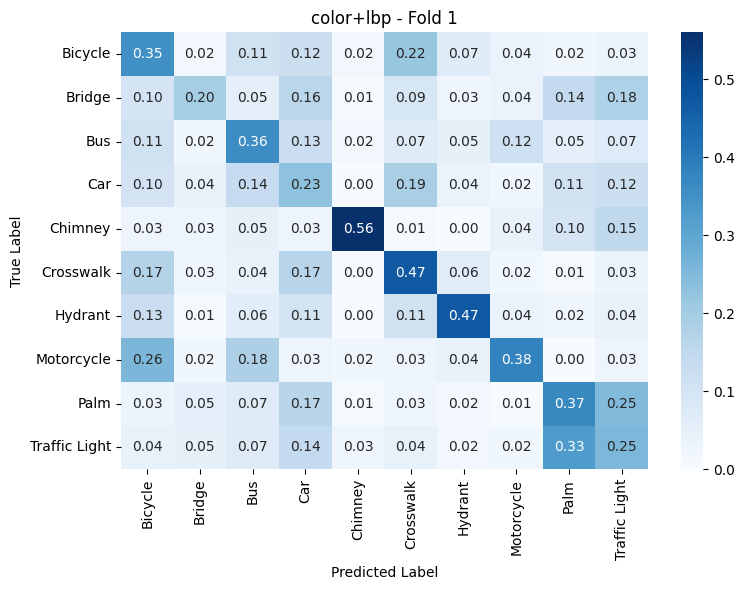


--- Ï°∞Ìï©: color+lbp+hog (Fold 1) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 1, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4806
    ‚îú Top-10 Accuracy: 0.8746 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3861 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4755 (Fold 1, Ï°∞Ìï© color+lbp+hog)


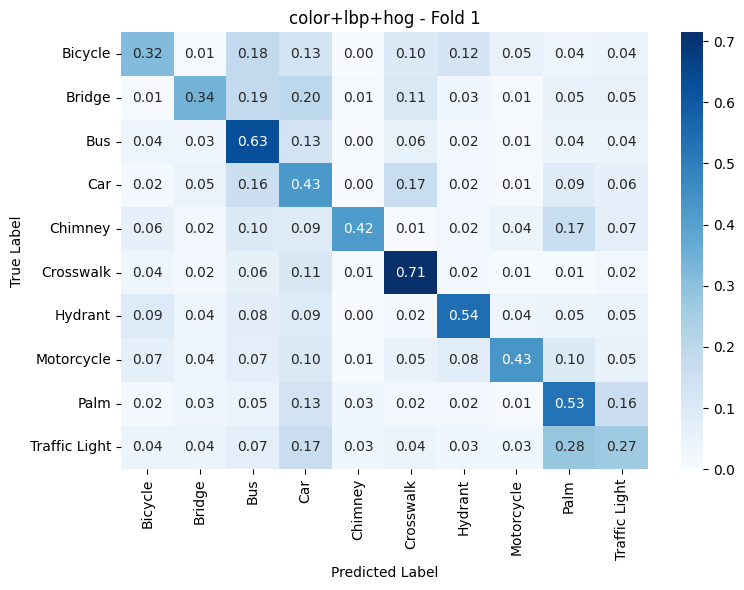


--- Ï°∞Ìï©: color+law+hog (Fold 1) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 1, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4791
    ‚îú Top-10 Accuracy: 0.8726 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3852 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4733 (Fold 1, Ï°∞Ìï© color+law+hog)


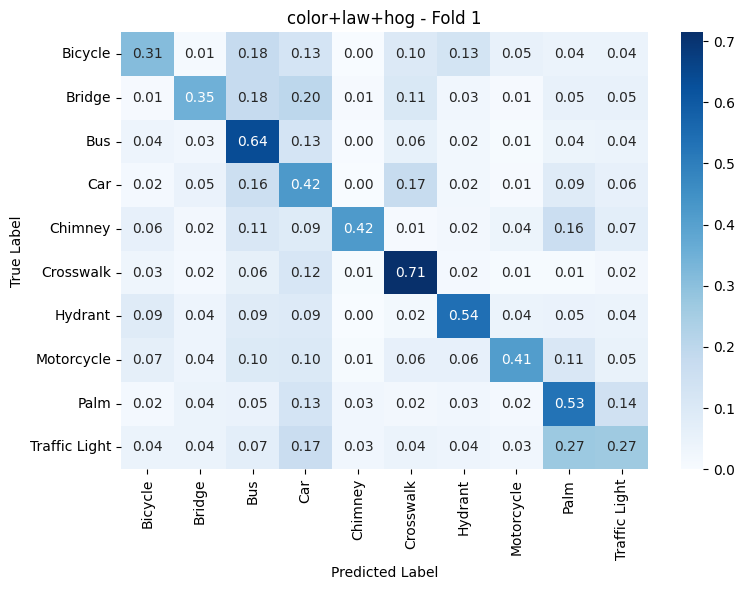


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 1) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (200 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 1, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 1, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4934
    ‚îú Top-10 Accuracy: 0.8908 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.4007 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4899 (Fold 1, Ï°∞Ìï© color+lbp+sift+hog)


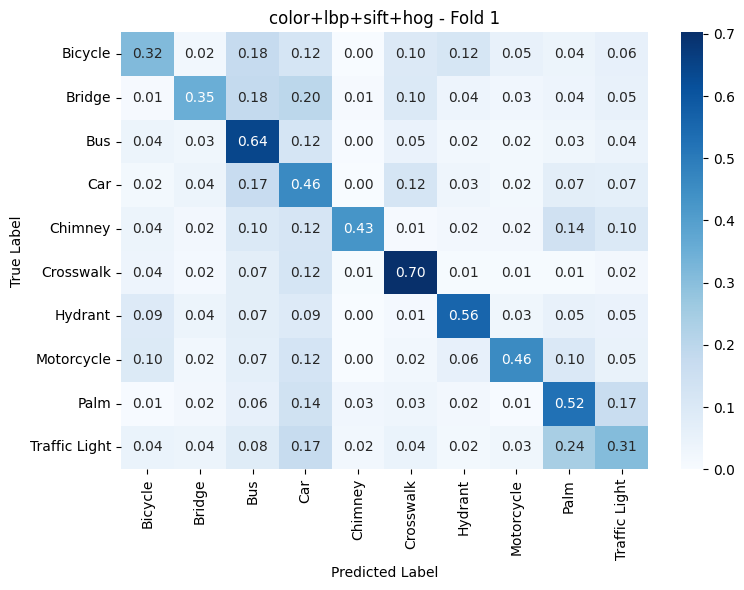


=============== FOLD 2/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 2)

--- Ï°∞Ìï©: color+lbp (Fold 2) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 2, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.3620
    ‚îú Top-10 Accuracy: 0.8485 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3166 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.3624 (Fold 2, Ï°∞Ìï© color+lbp)


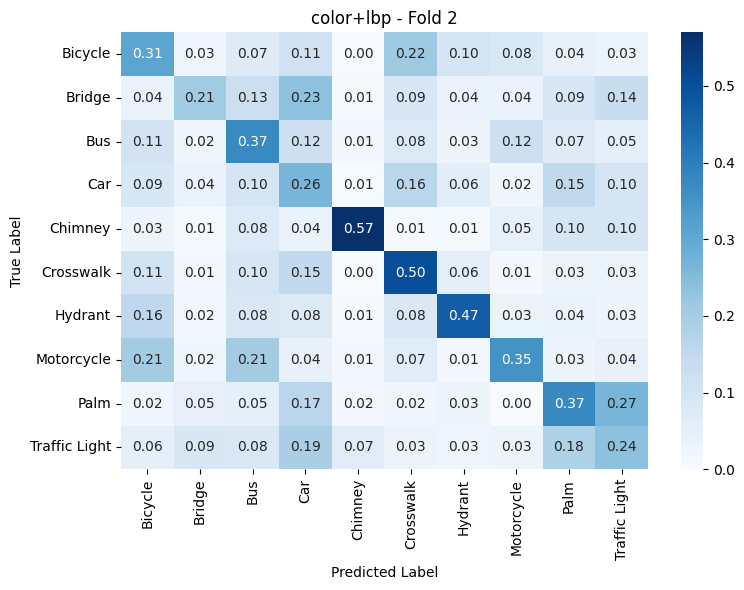


--- Ï°∞Ìï©: color+lbp+hog (Fold 2) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 2, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4727
    ‚îú Top-10 Accuracy: 0.8711 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3798 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4712 (Fold 2, Ï°∞Ìï© color+lbp+hog)


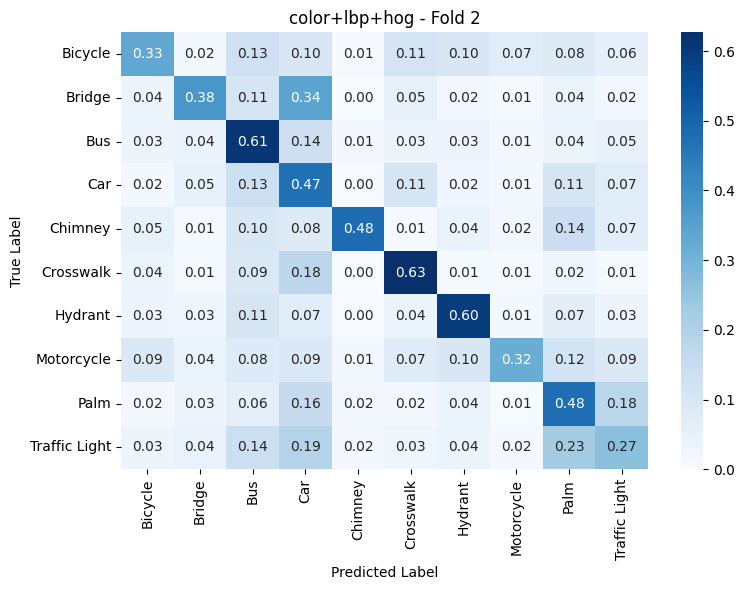


--- Ï°∞Ìï©: color+law+hog (Fold 2) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 2, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4727
    ‚îú Top-10 Accuracy: 0.8721 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3786 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4710 (Fold 2, Ï°∞Ìï© color+law+hog)


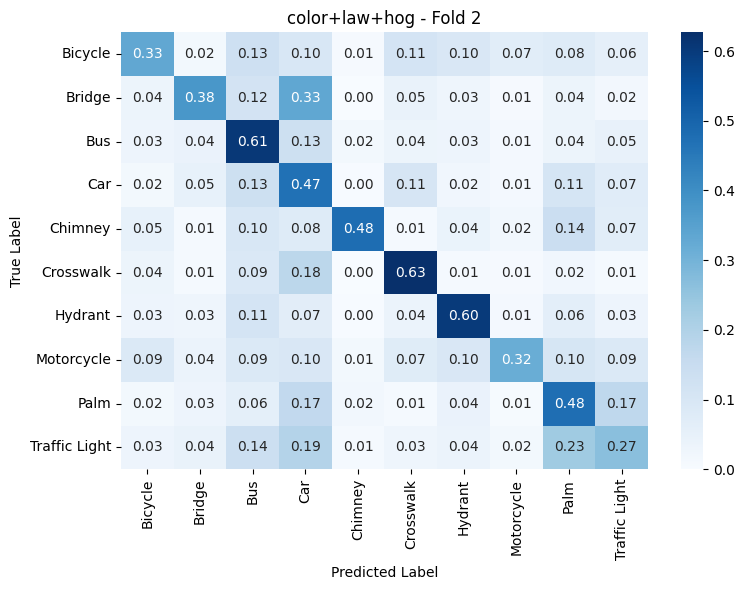


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 2) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (200 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 2, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 2, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4860
    ‚îú Top-10 Accuracy: 0.8879 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3941 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4879 (Fold 2, Ï°∞Ìï© color+lbp+sift+hog)


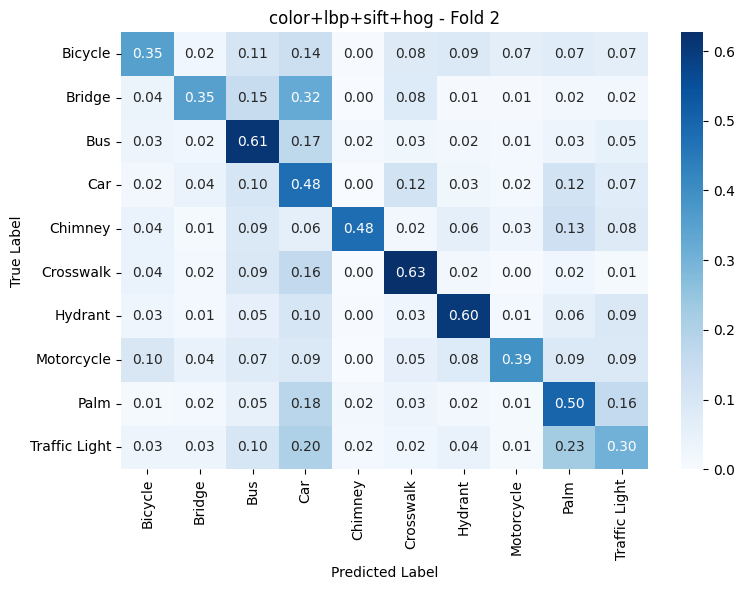


=============== FOLD 3/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 3)

--- Ï°∞Ìï©: color+lbp (Fold 3) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 3, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.3642
    ‚îú Top-10 Accuracy: 0.8602 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3172 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.3640 (Fold 3, Ï°∞Ìï© color+lbp)


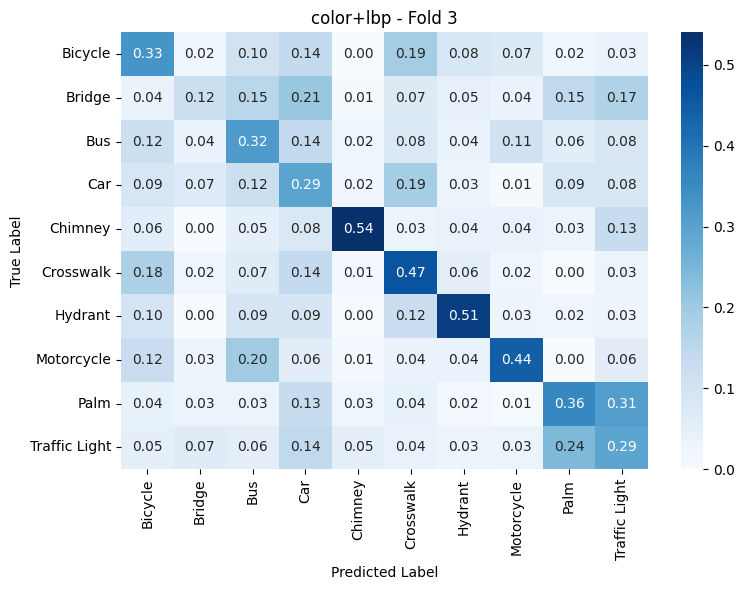


--- Ï°∞Ìï©: color+lbp+hog (Fold 3) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 3, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4823
    ‚îú Top-10 Accuracy: 0.8962 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3965 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4802 (Fold 3, Ï°∞Ìï© color+lbp+hog)


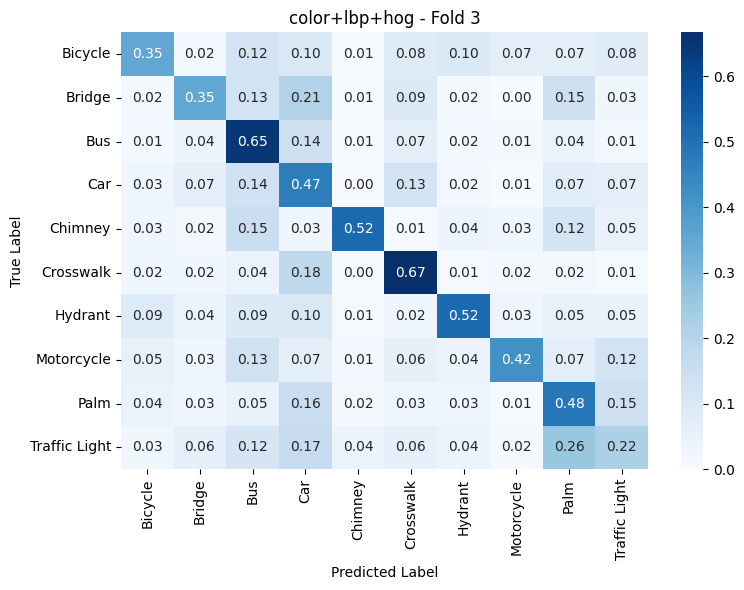


--- Ï°∞Ìï©: color+law+hog (Fold 3) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 3, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4833
    ‚îú Top-10 Accuracy: 0.8957 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3946 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4808 (Fold 3, Ï°∞Ìï© color+law+hog)


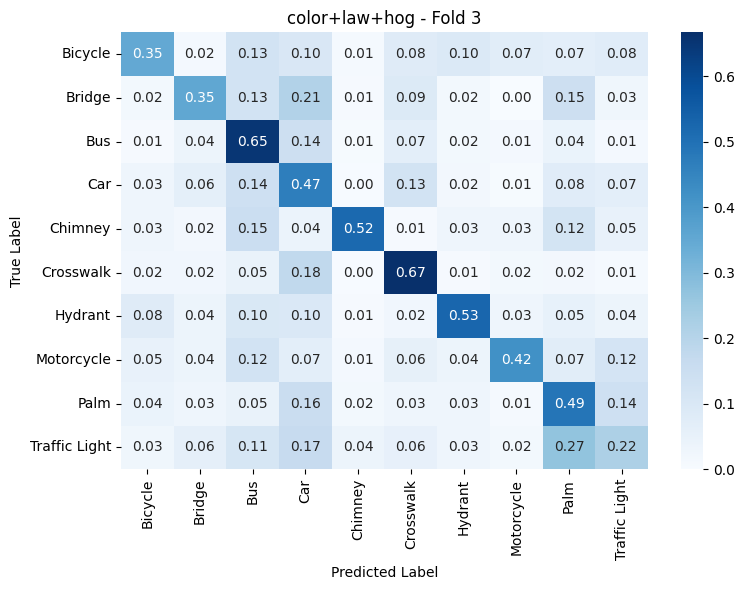


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 3) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (200 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 3, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 3, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4970
    ‚îú Top-10 Accuracy: 0.9090 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.4118 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4964 (Fold 3, Ï°∞Ìï© color+lbp+sift+hog)


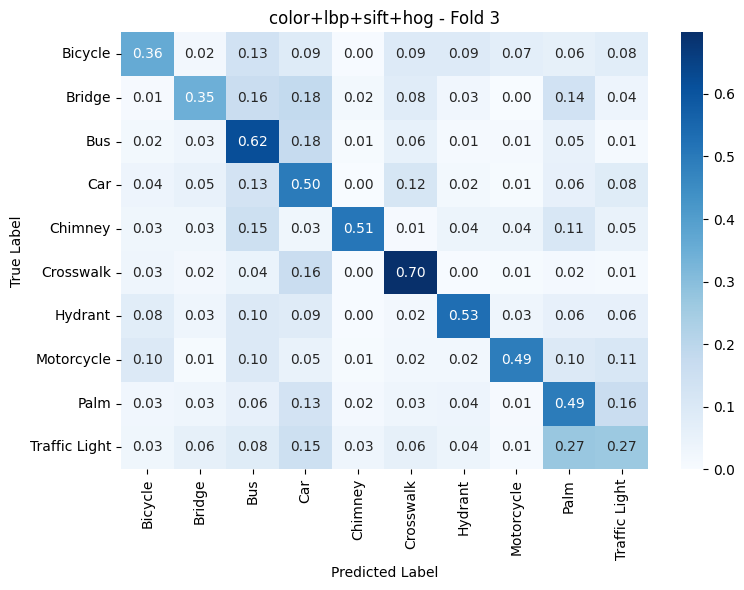


=============== FOLD 4/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 4)

--- Ï°∞Ìï©: color+lbp (Fold 4) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 4, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.3750
    ‚îú Top-10 Accuracy: 0.8652 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3193 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.3758 (Fold 4, Ï°∞Ìï© color+lbp)


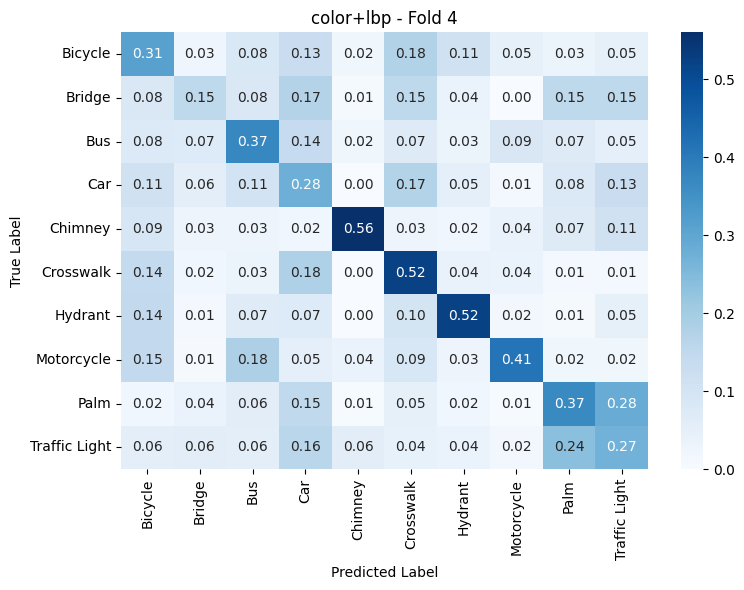


--- Ï°∞Ìï©: color+lbp+hog (Fold 4) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 4, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4926
    ‚îú Top-10 Accuracy: 0.8716 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3974 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4912 (Fold 4, Ï°∞Ìï© color+lbp+hog)


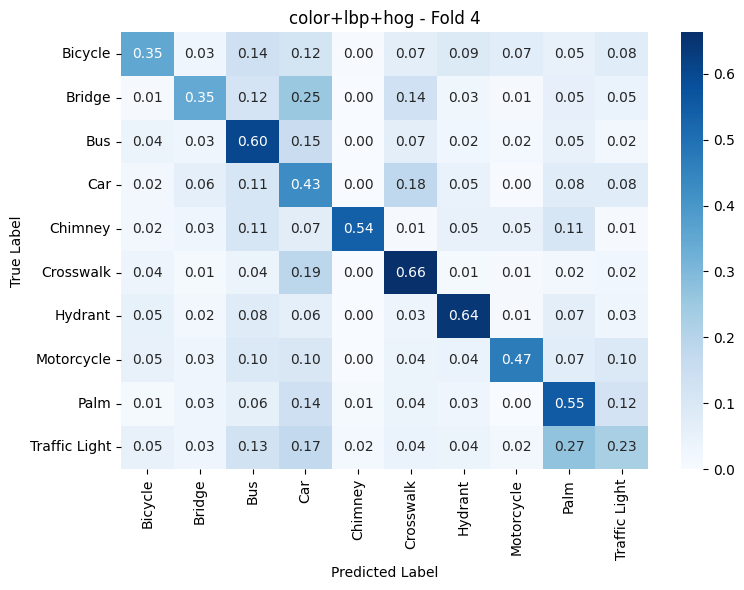


--- Ï°∞Ìï©: color+law+hog (Fold 4) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 4, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4941
    ‚îú Top-10 Accuracy: 0.8735 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3968 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4922 (Fold 4, Ï°∞Ìï© color+law+hog)


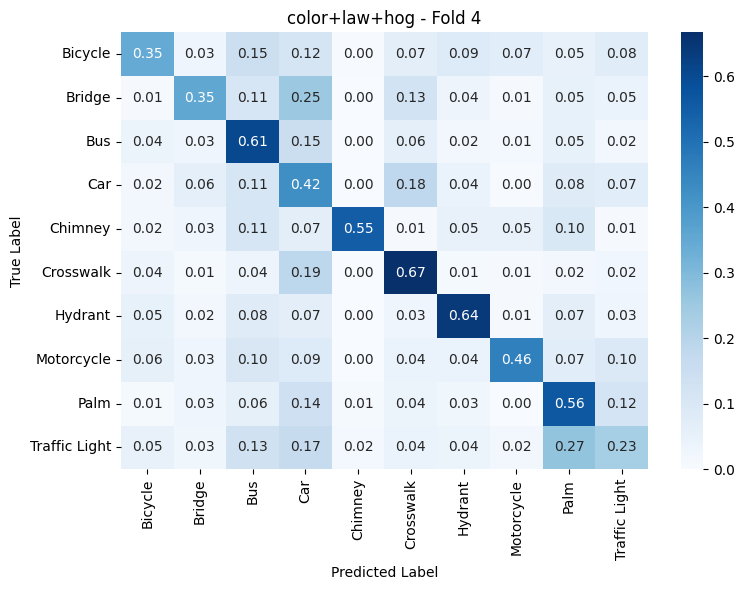


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 4) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (200 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 4, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 4, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.5103
    ‚îú Top-10 Accuracy: 0.8922 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.4096 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.5099 (Fold 4, Ï°∞Ìï© color+lbp+sift+hog)


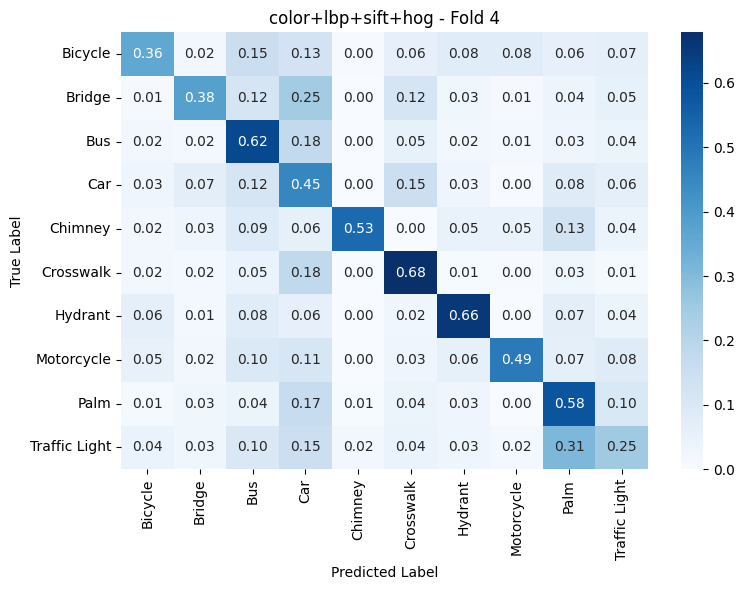


=============== FOLD 5/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 5)

--- Ï°∞Ìï©: color+lbp (Fold 5) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 5, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 5, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.3573
    ‚îú Top-10 Accuracy: 0.8647 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3186 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.3588 (Fold 5, Ï°∞Ìï© color+lbp)


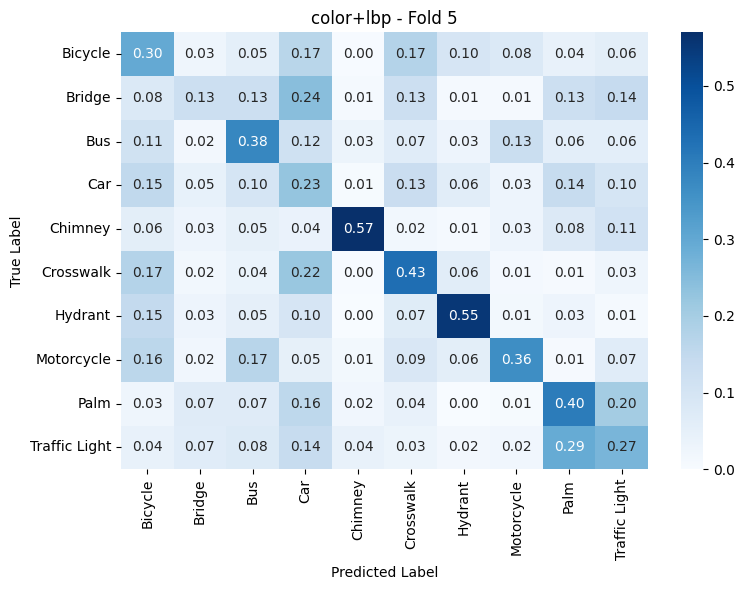


--- Ï°∞Ìï©: color+lbp+hog (Fold 5) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 5, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 5, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4852
    ‚îú Top-10 Accuracy: 0.8868 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3948 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4794 (Fold 5, Ï°∞Ìï© color+lbp+hog)


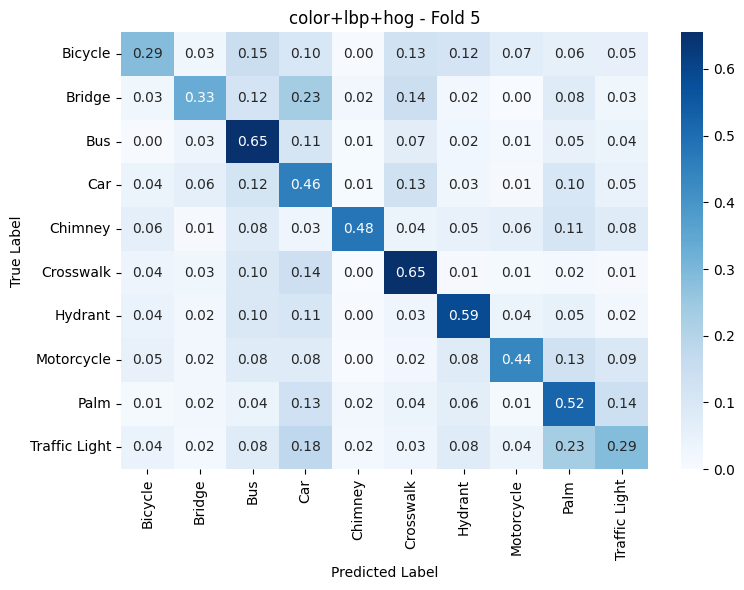


--- Ï°∞Ìï©: color+law+hog (Fold 5) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 5, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 5, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.4847
    ‚îú Top-10 Accuracy: 0.8873 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.3937 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.4787 (Fold 5, Ï°∞Ìï© color+law+hog)


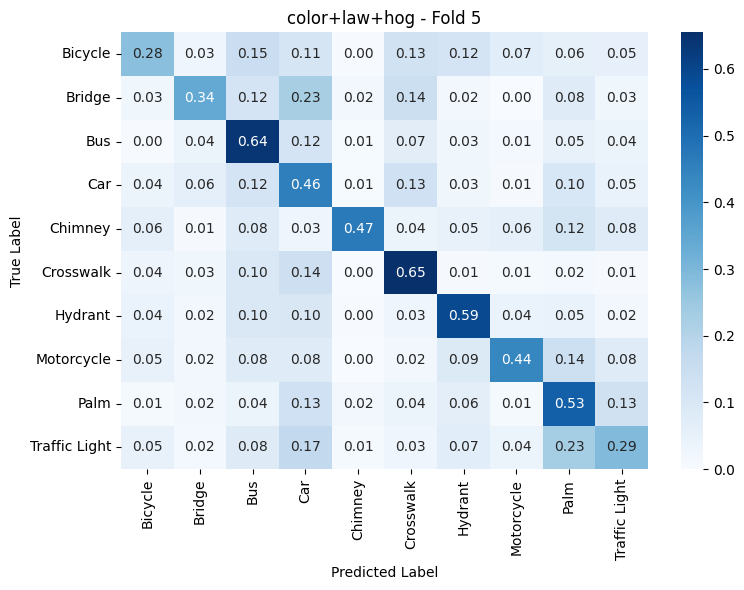


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 5) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (200 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 5, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 5, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=10, Fold 5, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å.
    ‚îú Top-1 Accuracy : 0.5069
    ‚îú Top-10 Accuracy: 0.9001 (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)
    ‚îî Task2 Score    : 0.4090 (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)
  ‚úî F1-Score: 0.5040 (Fold 5, Ï°∞Ìï© color+lbp+sift+hog)


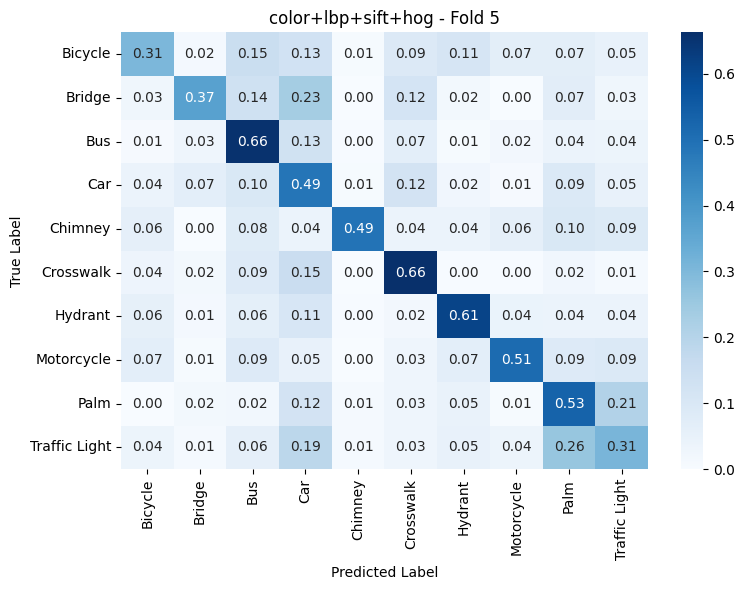



=============== ÏµúÏ¢Ö ÍµêÏ∞® Í≤ÄÏ¶ù Í≤∞Í≥º ================
ÌäπÏßï Ï°∞Ìï©: color+lbp
  Fold 1 Accuracy: 0.3586
  Fold 2 Accuracy: 0.3620
  Fold 3 Accuracy: 0.3642
  Fold 4 Accuracy: 0.3750
  Fold 5 Accuracy: 0.3573
  >> ÌèâÍ∑† Ï†ïÌôïÎèÑ: 0.3634 (ÌëúÏ§ÄÌé∏Ï∞®: 0.0063)
------------------------------
ÌäπÏßï Ï°∞Ìï©: color+lbp+hog
  Fold 1 Accuracy: 0.4806
  Fold 2 Accuracy: 0.4727
  Fold 3 Accuracy: 0.4823
  Fold 4 Accuracy: 0.4926
  Fold 5 Accuracy: 0.4852
  >> ÌèâÍ∑† Ï†ïÌôïÎèÑ: 0.4827 (ÌëúÏ§ÄÌé∏Ï∞®: 0.0065)
------------------------------
ÌäπÏßï Ï°∞Ìï©: color+law+hog
  Fold 1 Accuracy: 0.4791
  Fold 2 Accuracy: 0.4727
  Fold 3 Accuracy: 0.4833
  Fold 4 Accuracy: 0.4941
  Fold 5 Accuracy: 0.4847
  >> ÌèâÍ∑† Ï†ïÌôïÎèÑ: 0.4828 (ÌëúÏ§ÄÌé∏Ï∞®: 0.0070)
------------------------------
ÌäπÏßï Ï°∞Ìï©: color+lbp+sift+hog
  Fold 1 Accuracy: 0.4934
  Fold 2 Accuracy: 0.4860
  Fold 3 Accuracy: 0.4970
  Fold 4 Accuracy: 0.5103
  Fold 5 Accuracy: 0.5069
  >> ÌèâÍ∑† Ï†ïÌôïÎèÑ: 0.4987 (ÌëúÏ§ÄÌé∏Ï∞®: 0.0

In [38]:
# ÏÇ¨Ïö©Ìï† ÌäπÏßï Ï°∞Ìï© Ï†ïÏùò
#feature_names = ['color', 'hog', 'lbp', 'sift']
all_feature_combinations_tuples = []
#from itertools import combinations
#for i in range(1, len(feature_names) + 1):
#    for combo in combinations(feature_names, i):
#        all_feature_combinations_tuples.append(combo)

# ÏÇ¨Ïö©ÏûêÍ∞Ä ÏöîÏ≤≠Ìïú ÌäπÏ†ï Ï°∞Ìï© Ï∂îÍ∞Ä (ÌïÑÏöîÏãú)
user_requested_combinations = [
 ('color', 'lbp'), ('color', 'lbp', 'hog'),
 ('color', 'law', 'hog'),
 ('color', 'lbp', 'sift', 'hog')
]
all_feature_combinations_tuples.extend(user_requested_combinations)
# # Ï§ëÎ≥µ Ï†úÍ±∞
# all_feature_combinations_tuples = sorted(list(set(all_feature_combinations_tuples)))


print(f"\n‚ñ∂ Ï¥ù {len(all_feature_combinations_tuples)}Í∞úÏùò ÌäπÏßï Ï°∞Ìï©Ïóê ÎåÄÌï¥ ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ ÏàòÌñâÌï©ÎãàÎã§.")
for combo in all_feature_combinations_tuples:
    print(f"  - {combo}")

# Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
results = {}
confusion_matrices = {}

X_indices = np.arange(len(images_df)) # StratifiedKFoldÏóê ÏÇ¨Ïö©Ìï† Ïù∏Îç±Ïä§
y_labels = images_df['label_encoded'].values

# Stratified K-Fold Ï§ÄÎπÑ
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # ÎÖ∏Ìä∏Î∂ÅÏùò Í∏∞Î≥∏ 5-fold ÏÇ¨Ïö©
print("\n‚úî Stratified K-Fold ÏÑ§Ï†ï ÏôÑÎ£å (5-Fold)")

# ÍµêÏ∞® Í≤ÄÏ¶ù Î£®ÌîÑ
num_bovw_clusters = 200 # BoVW ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò (ÎÖ∏Ìä∏Î∂ÅÏùò get_features_for_split Ìï®Ïàò ÎÇ¥ num_bovw_clusters=200 Ï∞∏Í≥†, Ï§ÑÏó¨ÏÑú ÌÖåÏä§Ìä∏)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_indices, y_labels)):
    print(f"\n=============== FOLD {fold+1}/5 ================")
    y_train_fold, y_val_fold = y_labels[train_idx], y_labels[val_idx]
    # ÌòÑÏû¨ Ìè¥ÎìúÏùò SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ (ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïö©, Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïö©)
    sift_descriptors_train_fold = [sift_descriptors_list_all[i] for i in train_idx]
    sift_descriptors_val_fold = [sift_descriptors_list_all[i] for i in val_idx]

    print(f"  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold {fold+1})")
    # SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä ÌïòÎÇòÎèÑ ÏóÜÎäî Í≤ΩÏö∞Î•º Î∞©ÏßÄ
    valid_sift_descriptors_train_fold = [d for d in sift_descriptors_train_fold if d is not None and len(d) > 0]
    bovw_vocabulary = learn_bovw_vocabulary(valid_sift_descriptors_train_fold, num_clusters=num_bovw_clusters)


    # Í∞Å ÌäπÏßï Ï°∞Ìï©Ïóê ÎåÄÌï¥ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
    for feature_combo_tuple in all_feature_combinations_tuples:
        feature_combo_name = '+'.join(feature_combo_tuple)
        print(f"\n--- Ï°∞Ìï©: {feature_combo_name} (Fold {fold+1}) ---")
        
        X_train_features_list = []
        X_val_features_list = []
        
        if 'color' in feature_combo_tuple:
            X_train_features_list.append(features_color_all[train_idx])
            X_val_features_list.append(features_color_all[val_idx])
        if 'hog' in feature_combo_tuple:
            X_train_features_list.append(features_hog_all[train_idx])
            X_val_features_list.append(features_hog_all[val_idx])
        if 'lbp' in feature_combo_tuple:
            X_train_features_list.append(features_lbp_all[train_idx])
            X_val_features_list.append(features_lbp_all[val_idx])
        if 'laws' in feature_combo_tuple:
            X_train_features_list.append(features_laws_all[train_idx])
            X_val_features_list.append(features_laws_all[val_idx])    
        if 'sift' in feature_combo_tuple:
            if not valid_sift_descriptors_train_fold:
                print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: Fold {fold+1}Ïùò ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïóê Ïú†Ìö®Ìïú SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä ÏóÜÏñ¥ BoVW ÌäπÏßïÏùÑ ÏÉùÏÑ±Ìï† Ïàò ÏóÜÏäµÎãàÎã§. Ïù¥ Ï°∞Ìï©/Ìè¥ÎìúÎäî Í±¥ÎÑàÎúÅÎãàÎã§.")
                # Îπà ÌûàÏä§ÌÜ†Í∑∏Îû® ÎòêÎäî Ïò§Î•ò Ï≤òÎ¶¨
                num_features_sift = num_bovw_clusters 
                train_bovw_hist = np.zeros((len(train_idx), num_features_sift))
                val_bovw_hist = np.zeros((len(val_idx), num_features_sift))
            else:
                if bovw_vocabulary is None or bovw_vocabulary.shape[0] == 0 :
                     print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: Fold {fold+1}ÏóêÏÑú BoVW vocabulary ÌïôÏäµÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§. Ïù¥ Ï°∞Ìï©/Ìè¥ÎìúÎäî Í±¥ÎÑàÎúÅÎãàÎã§.")
                     num_features_sift = num_bovw_clusters 
                     train_bovw_hist = np.zeros((len(train_idx), num_features_sift))
                     val_bovw_hist = np.zeros((len(val_idx), num_features_sift))
                else:
                    print(f"  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å ({bovw_vocabulary.shape[0]} clusters).")
                    print(f"  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})...")
                    # Î≥ëÎ†¨ Ï≤òÎ¶¨ + Î≤°ÌÑ∞ÌôîÎêú ÌûàÏä§ÌÜ†Í∑∏Îû® ÏÉùÏÑ±
                    train_bovw_hist = np.array(parallel_create_bovw_histograms(sift_descriptors_train_fold, bovw_vocabulary, n_jobs=-1))
                    val_bovw_hist = np.array(parallel_create_bovw_histograms(sift_descriptors_val_fold, bovw_vocabulary, n_jobs=-1))

            X_train_features_list.append(train_bovw_hist)
            X_val_features_list.append(val_bovw_hist)

        if not X_train_features_list: # ÌäπÏßïÏù¥ ÌïòÎÇòÎèÑ ÏÑ†ÌÉùÎêòÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ (ÏùºÏñ¥ÎÇ† Ïùº ÏóÜÏßÄÎßå Î∞©Ïñ¥ ÏΩîÎìú)
            print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: ÌäπÏßïÏù¥ ÏÑ†ÌÉùÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§ ({feature_combo_name}). Í±¥ÎÑàÎúÅÎãàÎã§.")
            continue

        # ÌäπÏßï Í≤∞Ìï©
        X_train_combined = combine_features(*X_train_features_list)
        X_val_combined = combine_features(*X_val_features_list)
        
        # Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî (ÌïÑÏöîÏãú Ï∂îÍ∞Ä - Ïòà: StandardScaler ÎòêÎäî MinMaxScaler)
        # scaler = StandardScaler()
        # X_train_combined = scaler.fit_transform(X_train_combined)
        # X_val_combined = scaler.transform(X_val_combined)
        # print("  ‚ÑπÔ∏è ÌäπÏßï Ï†ïÍ∑úÌôî Ï†ÅÏö©Îê®.")

        print(f"  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})...")
        # NaN ÎòêÎäî Inf Í∞í ÌôïÏù∏ Î∞è Ï≤òÎ¶¨ (Ï§ëÏöî!)
        if np.isnan(X_train_combined).any() or np.isinf(X_train_combined).any():
            print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: X_train_combinedÏóê NaN ÎòêÎäî Inf Í∞íÏù¥ Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏäµÎãàÎã§. 0ÏúºÎ°ú ÎåÄÏ≤¥Ìï©ÎãàÎã§. (Ï°∞Ìï©: {feature_combo_name}, Fold: {fold+1})")
            X_train_combined = np.nan_to_num(X_train_combined, nan=0.0, posinf=0.0, neginf=0.0) # ÎòêÎäî Îã§Î•∏ ÎåÄÏ≤¥ Ï†ÑÎûµ
        if np.isnan(X_val_combined).any() or np.isinf(X_val_combined).any():
            print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: X_val_combinedÏóê NaN ÎòêÎäî Inf Í∞íÏù¥ Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏäµÎãàÎã§. 0ÏúºÎ°ú ÎåÄÏ≤¥Ìï©ÎãàÎã§. (Ï°∞Ìï©: {feature_combo_name}, Fold: {fold+1})")
            X_val_combined = np.nan_to_num(X_val_combined, nan=0.0, posinf=0.0, neginf=0.0)

        # ÌäπÏßï Î≤°ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÍ±∞ÎÇò Î™®Îì† Í∞íÏù¥ 0Ïù∏ Í≤ΩÏö∞Î•º Ï≤òÎ¶¨ (L2 Ï†ïÍ∑úÌôî Îì±ÏóêÏÑú Î¨∏Ï†ú Î∞úÏÉù Í∞ÄÎä•)
        if X_train_combined.shape[1] == 0:
            print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: ÌõàÎ†® ÌäπÏßï Î≤°ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÏäµÎãàÎã§. (Ï°∞Ìï©: {feature_combo_name}, Fold: {fold+1}). Í±¥ÎÑàÎúÅÎãàÎã§.")
            continue
        
        # FaissÎäî float32 ÌÉÄÏûÖÏùÑ ÏöîÍµ¨Ìï®
        X_train_combined = X_train_combined.astype(np.float32)
        X_val_combined = X_val_combined.astype(np.float32)

        try:
            # train KNN
            faiss_index, train_labels_for_pred, n_neighbors_actual = train_faiss_knn_euclidean(
                X_train_combined, y_train_fold, n_neighbors=10
            )
    
            print(f"  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k={n_neighbors_actual}, Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})...")

            # Top-k label list
            y_pred_topk = predict_faiss_knn_euclidean_topk(
                faiss_index, train_labels_for_pred, n_neighbors_actual, X_val_combined
            )

            # Top-1 predictions (Í∞ÄÏû• ÏïûÏóê ÏûàÎäî Í≤ÉÎßå ÏÇ¨Ïö©)
            y_pred_fold = [row[0] for row in y_pred_topk]

            # Í∏∞Ï°¥ ÌèâÍ∞Ä
            acc = accuracy_score(y_val_fold, y_pred_fold)
            fsc = f1_score(y_val_fold, y_pred_fold, average='weighted')

            # ‚¨áÔ∏è Top-10 Accuracy Í≥ÑÏÇ∞
            top10_hits = [true in top10 for true, top10 in zip(y_val_fold, y_pred_topk)]
            top10_acc = np.mean(top10_hits)

            def task2_score(y_true, topk_preds, topk=10):
                return np.mean([preds.count(t) / topk for t, preds in zip(y_true, topk_preds)])
            task2 = task2_score(y_val_fold, y_pred_topk, topk=10)

            print(f"  ‚úî ÏòàÏ∏° ÏôÑÎ£å.")
            print(f"    ‚îú Top-1 Accuracy : {acc:.4f}")
            print(f"    ‚îú Top-10 Accuracy: {top10_acc:.4f} (Ï†ïÎãµÏù¥ Top-10 ÏïàÏóê ÏûàÏúºÎ©¥ Ïù∏Ï†ï)")
            print(f"    ‚îî Task2 Score    : {task2:.4f} (Top-10 Ï§ë Ï†ïÎãµ Îì±Ïû• ÎπÑÏú® ÌèâÍ∑†)")
            print(f"  ‚úî F1-Score: {fsc:.4f} (Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})")

            # Confusion Matrix
            cm = confusion_matrix(y_val_fold, y_pred_fold)
            if feature_combo_name not in confusion_matrices:
                confusion_matrices[feature_combo_name] = {}
            confusion_matrices[feature_combo_name][fold] = cm

            if feature_combo_name not in results:
                results[feature_combo_name] = []
            results[feature_combo_name].append(acc)

            # ÏãúÍ∞ÅÌôî
            plot_confusion_matrix(
                cm,
                class_names=['Bicycle','Bridge','Bus', 'Car', 'Chimney','Crosswalk','Hydrant','Motorcycle','Palm','Traffic Light'],
                title=f'{feature_combo_name} - Fold {fold+1}',
                normalize=True
            )
        except Exception as e:
            print(f"  ‚ùå Ïò§Î•ò Î∞úÏÉù (Fold {fold+1}, Ï°∞Ìï© {feature_combo_name}): {e}")
            if feature_combo_name not in results:
                results[feature_combo_name] = []
            results[feature_combo_name].append(np.nan)

# ÏµúÏ¢Ö Í≤∞Í≥º ÏßëÍ≥Ñ Î∞è Ï∂úÎ†•
print("\n\n=============== ÏµúÏ¢Ö ÍµêÏ∞® Í≤ÄÏ¶ù Í≤∞Í≥º ================")
for combo_name, acc_list in results.items():
    valid_acc_list = [acc for acc in acc_list if not np.isnan(acc)]
    if valid_acc_list:
        mean_acc = np.mean(valid_acc_list)
        std_acc = np.std(valid_acc_list)
        print(f"ÌäπÏßï Ï°∞Ìï©: {combo_name}")
        for i, acc_fold in enumerate(acc_list):
             print(f"  Fold {i+1} Accuracy: {acc_fold:.4f}" if not np.isnan(acc_fold) else f"  Fold {i+1} Accuracy: Error")
        print(f"  >> ÌèâÍ∑† Ï†ïÌôïÎèÑ: {mean_acc:.4f} (ÌëúÏ§ÄÌé∏Ï∞®: {std_acc:.4f})")
    else:
        print(f"ÌäπÏßï Ï°∞Ìï©: {combo_name} - Î™®Îì† Ìè¥ÎìúÏóêÏÑú Ïò§Î•ò Î∞úÏÉù ÎòêÎäî Ïú†Ìö®Ìïú Í≤∞Í≥º ÏóÜÏùå.")
    print("-" * 30)

# Í∞ÄÏû• ÏÑ±Îä•Ïù¥ Ï¢ãÏùÄ Ï°∞Ìï© Ï∞æÍ∏∞ (ÌèâÍ∑† Ï†ïÌôïÎèÑ Í∏∞Ï§Ä)
if results:
    sorted_results = sorted(results.items(), key=lambda item: np.nanmean(item[1]) if item[1] else -1, reverse=True)
    print("\nüèÜ ÏµúÍ≥† ÏÑ±Îä• Ï°∞Ìï© (ÌèâÍ∑† Ï†ïÌôïÎèÑ Í∏∞Ï§Ä):")
    if sorted_results and np.nanmean(sorted_results[0][1]):
         best_combo_name, best_acc_list = sorted_results[0]
         print(f"  {best_combo_name}: ÌèâÍ∑† Ï†ïÌôïÎèÑ = {np.nanmean(best_acc_list):.4f}")
    else:
        print("  Ïú†Ìö®Ìïú Í≤∞Í≥ºÎ•º Í∞ÄÏßÑ Ï°∞Ìï©Ïù¥ ÏóÜÏäµÎãàÎã§.")